Load packages

In [11]:
import numpy as np
import radvel
import pickle
import pandas as pd
import sys
import re
import dynesty
DATADIR = "../data/"
sys.path+= ["../"]
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from ResonantRV_Utils import get_acr_like, get_radvel_like
from ResonantPairModel import ACRModelPrior, ACRModelPriorTransform
from ResonantPairModel import RadvelModelPriorTransform

# Example RV Fitting

This notebook constains examples demonstrating our RV fitting techniques.
The notebook is split into two sections illustrating the 'full' and 'ACR' models in turn.
In each section we conduct MCMC and nested sampling fits to compute posterior samples and estimate the Baysian evidence of the model. We generate `radvel.likelihood.CompositeLikelihood` and `radvel.posterior.Posterior` objects for the model under consideration.  The posterior objects are used in a MCMC fit to generate posterior samples.  The likelihood objects are used along side a transformation of the unit cube to run a nested sampling algorithm using `dynesty`.


We begin by selecting our example system as  **HD 116029**

In [13]:
ObservationsDF = pd.read_pickle(DATADIR+"All_Observations.pkl")
system='HD 116029'
Observations = ObservationsDF.query('system==@system')

## 1. 'Full' model

Select observations for specific system

Generate `radvel` likelihood object for 'Full' model

In [14]:
full_model_like = get_radvel_like(Observations)

Set initial values of 'like' object parameters to the median values from a previous MCMC fit.
The values of some of these parameters are used below to fix appropriate prior ranges for nested sampling.

In [15]:
try:
    # Get MCMC posterior sample file
    dname = re.sub("HD ","HD",system)
    dname = re.sub("BD\+20 ","BD+20_",dname)
    datadir = DATADIR+dname
    with open(datadir+"/full_model_post_v2.0.pkl","rb") as fi:
        posterior_samples = pickle.load(fi)
    for key in full_model_like.list_vary_params():
        if key in posterior_samples.columns.values:
            full_model_like.params[key].value = posterior_samples[key].median()
except:
    print(
    """ 
    Didn't find file: \n\n\t{}\n
    containing posterior samples from an MCMC fit. 
    You'll have to find your own way to initialize
    the parameter values in 'like' to a good 
    starting point.
    """.format(datadir+"/full_model_post_v2.0.pkl")
    )

Create posterior object for radvel MCMC fit

In [16]:
k1med = posterior_samples['k1'].median()
k2med = posterior_samples['k2'].median()

In [18]:
full_model_post = radvel.posterior.Posterior(full_model_like)
full_model_priors = [
    radvel.prior.Jeffreys('k1',0.2 * k1med, 5 * k1med ),
    radvel.prior.Jeffreys('k2',0.2 * k2med, 5 * k2med ),
    radvel.prior.EccentricityPrior(2)
]
full_model_post.priors += full_model_priors

Get max-likelihood starting point using scipy's minimize

In [19]:
from scipy.optimize import minimize

In [21]:
print("Before fit: logprob: {:.2f}, loglike: {:.2f}".format(full_model_post.logprob(),full_model_like.logprob()))

minresult = minimize(full_model_post.neglogprob_array,full_model_post.get_vary_params())

print("After fit: logprob: {:.2f}, loglike: {:.2f}".format(full_model_post.logprob(),full_model_like.logprob()))

Before fit: logprob: -92.98, loglike: -84.13
After fit: logprob: -90.42, loglike: -81.57


Take a look at the fit

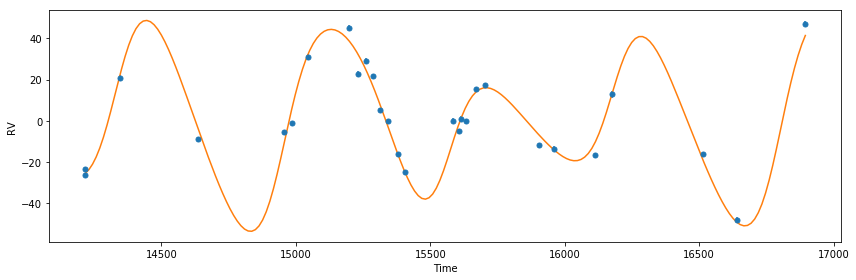

In [23]:
from ResonantRV_Utils import plot_fit
plot_fit(full_model_post.likelihood)

### 1.1 MCMC Fitting
 This section runs `radvel`'s MCMC fit to generate posterior samples.  
 
 
Note that parameterization used by our `full_model_post` object is probably not ideal for MCMC sampling; usually MCMC jumps have higher acceptance rate if we parameterize eccentricies and arguments of periapse are sampled in cartesian coordinates. Nonetheless, the MCMC doesn't appear to have much trouble.


In [24]:
mcmc_results = radvel.mcmc(full_model_post)

200000/4000000 (5.0%) steps complete; Running 9435.88 steps/s; Mean acceptance rate = 31.4%; Min Tz = 6990.9; Max G-R = 1.004      
Discarding burn-in now that the chains are marginally well-mixed

560000/4000000 (14.0%) steps complete; Running 11114.05 steps/s; Mean acceptance rate = 16.1%; Min Tz = 3244.8; Max G-R = 1.009      
Chains are well-mixed after 560000 steps! MCMC completed in 52.1 seconds




Plot posterior distributions of semi-amplitudes and compare with the old saved samples. Note that the new samples are saved with 

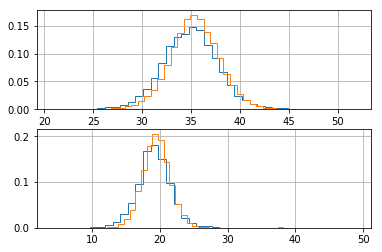

In [29]:
fig,ax= plt.subplots(2)

mcmc_results.k1.hist(bins=40,histtype='step',ax=ax[0],normed=True)
posterior_samples.k1.hist(bins=40,histtype='step',ax=ax[0],normed=True)

mcmc_results.k2.hist(bins=40,histtype='step',ax=ax[1],normed=True)
posterior_samples.k2.hist(bins=40,histtype='step',ax=ax[1],normed=True)

### 1.2 Nested sampling fit

Generate a (callable) prior transform object that defines a mapping from the unit hyper-cube to the parameters appearing in the likelihood model. The unit-hypercube is sampled uniformly by the nested sampling algorithm.

In [31]:
full_model_prior_transform = RadvelModelPriorTransform(Observations,full_model_like)

Get a dynesty NestedSample object

In [32]:
full_model_nested_sampler = dynesty.NestedSampler(
    full_model_like.logprob_array,
    full_model_prior_transform,
    full_model_prior_transform.Npars,
    sample='rwalk'
)

Run nested sampling

In [33]:
_ = full_model_nested_sampler.run_nested()

iter: 15314 | +500 | bound: 223 | nc: 1 | ncall: 356805 | eff(%):  4.432 | loglstar:   -inf < -83.422 <    inf | logz: -113.480 +/-  0.251 | dlogz:  0.001 >  0.509                                   

Save the results of nested sampling run.

In [34]:
full_model_nested_results = full_model_nested_sampler.results

In [35]:
full_model_nested_results['logz'][-1]

-113.47956174177965

## 2. ACR model

Generate likelihood object for ACR model

In [36]:
acr_model_like = get_acr_like(Observations,3,1)

Set initial values of 'like' object parameters to the median values from a previous MCMC fit.
The values of some of these parameters are used below to fix appropriate prior ranges for nested sampling.

In [37]:
try:
    # Get MCMC posterior sample file
    dname = re.sub("HD ","HD",system)
    dname = re.sub("BD\+20 ","BD+20_",dname)
    datadir = DATADIR+dname
    with open(datadir+"/full_model_post_v2.0.pkl","rb") as fi:
        posterior_samples = pickle.load(fi)
    for key in acr_model_like.list_vary_params():
        if key in posterior_samples.columns.values:
            acr_model_like.params[key].value = posterior_samples[key].median()
except:
    print(
    """ 
    Didn't find file: \n\n\t{}\n
    containing posterior samples from an MCMC fit. 
    You'll have to find your own way to initialize
    the parameter values in 'like' to a good 
    starting point.
    """.format(datadir+"/full_model_post_v2.0.pkl")
    )

Create posterior object for radvel MCMC fit

In [38]:
acr_model_post = radvel.posterior.Posterior(acr_model_like)
acrpriors = [
    ACRModelPrior(),
    radvel.prior.Jeffreys('k1',0.2 * k1med, 5 * k1med ),
    radvel.prior.Jeffreys('m2_by_m1',0.1,10)
]
acr_model_post.priors += acrpriors

Get max-likelihood starting point using scipy's minimize

In [39]:
from scipy.optimize import minimize

In [40]:
print("Before fit: logprob: {:.2f}, loglike: {:.2f}".format(acr_model_post.logprob(),acr_model_post.logprob()))

minresult = minimize(acr_model_post.neglogprob_array,acr_model_post.get_vary_params())

print("After fit: logprob: {:.2f}, loglike: {:.2f}".format(acr_model_post.logprob(),acr_model_post.logprob()))

Before fit: logprob: -195.56, loglike: -195.56
After fit: logprob: -103.51, loglike: -103.51


Take a look at the fit

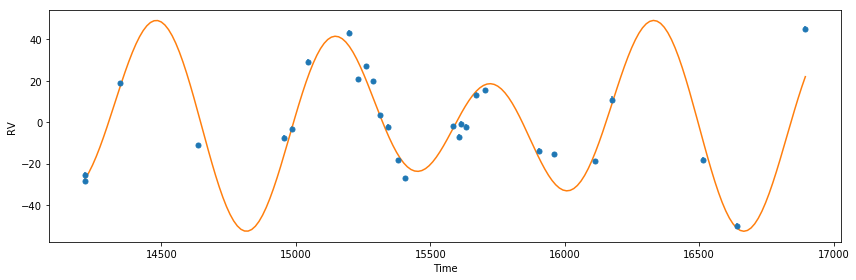

In [42]:
from ResonantRV_Utils import plot_fit
plot_fit(acr_model_post.likelihood)

### 2.1 MCMC Fit

In [43]:
acr_model_mcmc_results = radvel.mcmc(acr_model_post)

200000/4000000 (5.0%) steps complete; Running 14467.83 steps/s; Mean acceptance rate = 44.0%; Min Tz = 1071.6; Max G-R = 1.027      
Discarding burn-in now that the chains are marginally well-mixed

820000/4000000 (20.5%) steps complete; Running 10996.79 steps/s; Mean acceptance rate = 41.9%; Min Tz = 5316.1; Max G-R = 1.005      
Chains are well-mixed after 820000 steps! MCMC completed in 1.1 minutes




The cells below show the eccentricity posteriors of the ACR model. 
ACR tracks for the 1st and 99th percentile $m_2/m_1$ values are plotted for comparison.

In [44]:
# Get planet eccentricities at posterior samples.
# Caution: iterrows is annoyingly slow...
e1,e2=[],[]
for i,x in  acr_model_mcmc_results[acr_model_post.likelihood.list_vary_params()].iterrows():
    acr_model_post.likelihood.set_vary_params(x)
    e1.append( acr_model_post.likelihood.model.get_synthparams()['e1'].value )
    e2.append( acr_model_post.likelihood.model.get_synthparams()['e2'].value )
acr_model_mcmc_results['e1'] = e1
acr_model_mcmc_results['e2'] = e2

(0, 0.4)

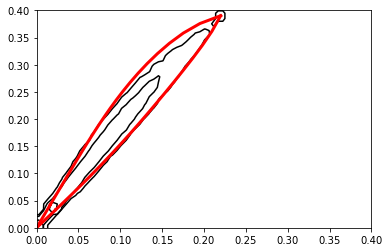

In [56]:
from corner import hist2d

from scipy.special import erf
fig,ax = plt.subplots(1)

hist2d(
    acr_model_mcmc_results['e1'].values,acr_model_mcmc_results['e2'].values,
    bins = 40,
    levels=[erf(i/np.sqrt(2)) for i in range(1,4)],
    plot_datapoints=False, plot_density=False,
    ax = ax    
)

for mratio in acr_model_mcmc_results.m2_by_m1.quantile((.01,0.99)):
    x,y = np.transpose([ acr_model_post.likelihood.model._acr_curves_fn(mratio,t) for t in np.linspace(0,1)])
    ax.plot(x,y,lw=3,color='red')
ax.set_xlim(0,0.4)
ax.set_ylim(0,0.4)

### 2.2 Nested sampling fit

Generate a (callable) prior transform object that defines a mapping from the unit hyper-cube to the parameters appearing in the likelihood model. The unit-hypercube is sampled uniformly by the nested sampling algorithm.

In [46]:
acr_model_prior_transform = ACRModelPriorTransform(Observations,acr_model_like)

Get a dynesty NestedSample object

In [47]:
sampler_acr_model = dynesty.NestedSampler(
    acr_model_like.logprob_array,
    acr_model_prior_transform,
    acr_model_prior_transform.Npars,
    sample='rwalk'
)

Run nested sampling

In [48]:
_ = sampler_acr_model.run_nested()

iter: 11884 | +500 | bound: 147 | nc: 1 | ncall: 271404 | eff(%):  4.563 | loglstar:   -inf < -85.013 <    inf | logz: -108.188 +/-  0.221 | dlogz:  0.001 >  0.509                                   

Save the results of nested sampling run.

In [49]:
acr_model_nested_results = sampler_acr_model.results

In [50]:
acr_model_nested_results['logz'][-1]

-108.18767368804208

# Model comparison

All that is left to do now is to compute the log of our Bayesian odds ratio for our two models:
$$
\log\left(\frac{{\cal Z}_{ACR}}{{\cal Z}_{full}}\right)
$$

In [52]:
acr_model_nested_results['logz'][-1] - full_model_nested_results['logz'][-1]

5.291888053737566